<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/3_AutoRegressive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the raw data for autoregressive models

In the previous notebook, we gained some insights on certain aspects of our data. In this notebook, we shall run the classical auto-regressive ARIMA model and see its performance.

In [3]:
import pandas as pd

## Raw data csv is also made available for the select stations in URL:
url = "https://drive.google.com/uc?export=download&id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq"
localurl = "./timeseries_data/raw_data_DOWNLOADED.csv"
dataframe = pd.read_csv(localurl,parse_dates=["datetime"])
variable_column = "temp"
## Else if using local files:
# import os
# TIMESERIES_DATA_DIR = "./content/timeseries_data/"
# dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "raw_data.csv"))
dataframe.head()

,longitude,latitude,station_code,datetime,temp
0,7.567796,47.819182,DEBW073,1997-01-01 00:00:00+00:00,-10.0
1,7.567796,47.819182,DEBW073,1997-01-01 01:00:00+00:00,-11.0
2,7.567796,47.819182,DEBW073,1997-01-01 02:00:00+00:00,-11.0
3,7.567796,47.819182,DEBW073,1997-01-01 03:00:00+00:00,-12.0
4,7.567796,47.819182,DEBW073,1997-01-01 04:00:00+00:00,-12.0


In [4]:
dataframe.shape

(579480, 5)

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [4]:
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, variable_column, n_past=336, n_future=96):
    df = data.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['station_code', 'datetime']).reset_index(drop=True)

    # 1) Encode station_code as a small integer (categorical codes) to save memory
    df['sc_code'] = df['station_code'].astype('category')

    # 2) Boolean mask: True if exactly 1 hour after the previous row (per station)
    is1h = (
        df.groupby('station_code')['datetime']
          .diff()
          .eq(pd.Timedelta(hours=1))
    )

    # 3) Compute how many consecutive “True” over (n_past + n_future - 1) rows
    gap_window = n_past + n_future - 1
    run = (
        is1h.groupby(df['station_code'])
            .rolling(window=gap_window, min_periods=gap_window)
            .sum()
            .reset_index(level=0, drop=True)
    )

    # 4) 'ends' are indices where run == gap_window (end of a full-length continuous block)
    ends = run[run == gap_window].index

    # 5) Grab column‐arrays for encoded station code and the variable
    sc_arr  = df['sc_code'].values
    vals    = df[variable_column].values

    X_list = []
    y_list = []
    for end_idx in ends:
        start_idx = end_idx - gap_window
        if start_idx >= 0 and sc_arr[start_idx] == sc_arr[end_idx]:
            station_block = sc_arr[start_idx : end_idx + 1]
            var_block     = vals[start_idx : end_idx + 1]

            block = np.column_stack((station_block, var_block))

            X_list.append(block[:n_past, :])
            y_list.append(block[n_past:, :])

    if not X_list:
        # No valid windows
        return np.empty((0, n_past, 2)), np.empty((0, n_future, 2))

    X = np.stack(X_list)  # shape = (num_windows, n_past, 2)
    y = np.stack(y_list)  # shape = (num_windows, n_future, 2)
    return X, y

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [ ]:
context_window = 336
prediction_horizon = 96

X, y = create_sequences(dataframe,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7) # ! This is problematic, see last cell for explanation
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

### Forecasting with MA models: SARIMAX


😈 **Task 1:** Try modeling without seasonal terms. How do AIC and RMSE compare?

😈 **Task 2:** Add an exogenous variable like `o3` into SARIMAX and observe results.

😈 **Question 1:** How does adding an exogenous variable enhance forecasting in SARIMAX?




ADF p-value: 0.00014673595344870535


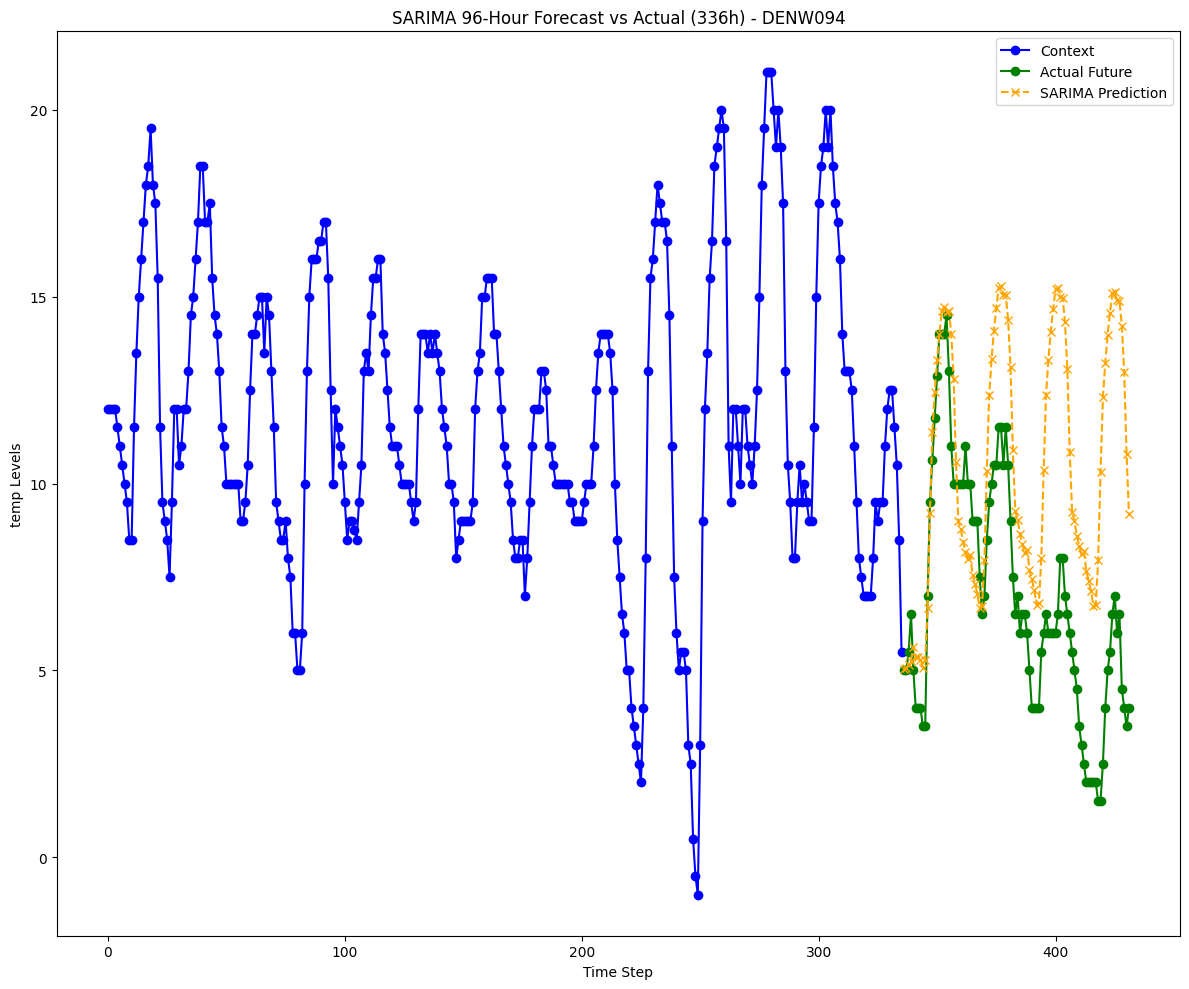

Mean Squared Error (MSE): 22.917


,SARIMA Summary
DENW094,SARIMAX R...


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Define forecast horizon (96 hours = 4 days)
forecast_hours = 96

sarima_results = {}

# First sample of DENW094 station to compare with PatchTST
X_first_idx = np.flatnonzero(X_test[:, 0, 0] == 'DENW094')[0]
X_test_sample=X_test[X_first_idx, :, 1].astype(np.float32) # First column is station code hence adding 1
# First sample of DENW094 station to compare with PatchTST
y_first_idx = np.flatnonzero(X_test[:, 0, 0] == 'DENW094')[0]
y_test_sample=y_test[y_first_idx, :, 1].astype(np.float32) # First column is station code hence adding 1

# Check stationarity using ADF test
adf_test = adfuller(X_test_sample)
p_value = adf_test[1]
print(f"ADF p-value: {p_value}")

# Differencing if needed
d = 0 if p_value < 0.05 else 1  # If p-value < 0.05, it's stationary
seasonal_period = 24

# Fit SARIMA model
try:
    sarima_model = SARIMAX(X_test_sample,
        order=(1, d, 1),
        seasonal_order=(1, d, 1, seasonal_period),
        enforce_stationarity=False,
        enforce_invertibility=False).fit()

    fitted_values = sarima_model.fittedvalues
    forecast = sarima_model.get_forecast(steps=forecast_hours)
    forecast_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 10))

    plt.plot(range(context_window),  X_test_sample, label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), y_test_sample, label="Actual Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), forecast_values, label="SARIMA Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"SARIMA 96-Hour Forecast vs Actual (336h) - DENW094")
    plt.xlabel("Time Step")
    plt.ylabel("temp Levels")
    plt.legend()
    plt.tight_layout()
    plt.show()

    sarima_results["DENW094"] = sarima_model.summary()

    mse = mean_squared_error(y_test_sample, forecast_values)
    print(f"Mean Squared Error (MSE): {mse:.3f}")

except Exception as e:
    sarima_results['DENW094'] = f"Error: {e}"

sarima_results_df = pd.DataFrame.from_dict(sarima_results, orient='index', columns=['SARIMA Summary'])
display(sarima_results_df)


## Data Preprocessing (Normalization)

the snippet below uses standard Z normalization (this is a simple snippet alternatively other approaches could also be used as desired)


😈 **Task 3:** Implement min-max normalization and compare the results visually with Z-score.


In [7]:
import requests
import json
import pandas as pd
import os
import csv
from datetime import datetime

# German stations with good distribution temp variable observations
station_codes = ["DENW094", "DEBW073","DEHE020"]
variable_columns = ["temp"]
# station_codes = ["DENW094"]
# variable_columns = ["no2", "temp", "o3", "no", "press"]

In [8]:
def standard_scaler(df, columns):
    """
    Standardize the specified columns of a DataFrame by subtracting the mean
    and dividing by the standard deviation (Z-score normalization).

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to be normalized.

    Returns:
        pd.DataFrame: DataFrame with normalized columns.
    """

    df_scaled = df.copy()
    for col in columns:
        df_scaled[col] = (
            df_scaled
            .groupby("station_code")[col]
            .transform(lambda x: (x - x.mean()) / x.std())
        )
    return df_scaled

In [9]:
dataframes = standard_scaler(dataframe, variable_columns)
dataframes.head()

,longitude,latitude,station_code,datetime,temp
0,7.567796,47.819182,DEBW073,1997-01-01 00:00:00+00:00,-2.564191
1,7.567796,47.819182,DEBW073,1997-01-01 01:00:00+00:00,-2.686422
2,7.567796,47.819182,DEBW073,1997-01-01 02:00:00+00:00,-2.686422
3,7.567796,47.819182,DEBW073,1997-01-01 03:00:00+00:00,-2.808654
4,7.567796,47.819182,DEBW073,1997-01-01 04:00:00+00:00,-2.808654


In [11]:
TIMESERIES_DATA_DIR = "./timeseries_data/"
dataframes.to_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data_FROM_DOWNLOADED.csv"), index=False)
dataframes.shape

(580016, 5)

### Load the normalized data preparing samples for ML models.


> Samples are needed for sequence models and transformer models for input

😈 **Task 4:** What are some key differences between AR models and sequence models like RNNs or Transformers?

😈 **Question 2:** Why is it important to maintain time continuity when preparing samples for sequence models?



In [1]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
#url = "https://drive.google.com/uc?export=download&id=1Eui59GyTXNv839WijdZ0CkzuMubmZQz1"
localurl = "./timeseries_data/normalized_data_DOWNLOADED.csv"
dataframe = pd.read_csv(localurl,parse_dates=["datetime"])
## Else if using local files:
# dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
variable_column = "temp"
dataframe.shape

(579480, 5)

80/20 train/test split chosen for illustration

😈 **Task 5:** Try a rolling-window cross-validation strategy. How does model performance vary?

😈 **Question 3:** What are the pitfalls of using random splits in timeseries forecasting?


In [13]:
context_window = 336
prediction_horizon = 96

X, y = create_sequences(dataframe,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7) # ! This is problematic, see last cell for explanation
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (374158, 336, 2), y_train shape: (374158, 96, 2)
X_test shape: (160354, 336, 2), y_test shape: (160354, 96, 2)


In [15]:
import pickle

with open("./content/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("./content/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("./content/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("./content/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("Train/test datasets saved successfully.")

Train/test datasets saved successfully.


In [1]:
import pickle
## Processed data .pkl files are also made available for the select stations in URL
# Please download the files and place them in content subfolder
# else modify below path according to your chosen local download path:
# univariate case (temp) : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("./X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("./X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("./y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("./y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (373938, 336, 2), y_train shape: (373938, 96, 2)
X_test shape: (160260, 336, 2), y_test shape: (160260, 96, 2)


# Resolve .pkl issue:

In [2]:
# 🔍 VALIDATION: Check station distribution in pkl files
import numpy as np

print("="*60)
print("VALIDATING TRAIN/TEST SPLIT METHODOLOGY")
print("="*60)

# Expected stations from the data creation process
expected_stations = ["DENW094", "DEBW073", "DEHE020"]

print("\n1️⃣ CHECKING STATION PRESENCE IN TRAIN/TEST SETS:")
print("-" * 50)

for dataset_name, X_data in [("TRAIN", X_train), ("TEST", X_test)]:
    print(f"\n{dataset_name} SET:")
    unique_stations = np.unique(X_data[:, 0, 0])
    print(f"  📊 Total samples: {len(X_data)}")
    print(f"  🏢 Stations found: {unique_stations}")
    
    for station in expected_stations:
        station_count = np.sum(X_data[:, 0, 0] == station)
        percentage = (station_count / len(X_data)) * 100
        print(f"    - {station}: {station_count:6d} samples ({percentage:5.1f}%)")

print("\n2️⃣ STATION-WISE TRAIN/TEST DISTRIBUTION:")
print("-" * 50)

for station in expected_stations:
    train_count = np.sum(X_train[:, 0, 0] == station)
    test_count = np.sum(X_test[:, 0, 0] == station)
    total_count = train_count + test_count
    
    if total_count > 0:
        train_pct = (train_count / total_count) * 100
        test_pct = (test_count / total_count) * 100
        print(f"\n{station}:")
        print(f"  📈 Train: {train_count:6d} ({train_pct:5.1f}%)")
        print(f"  📉 Test:  {test_count:6d} ({test_pct:5.1f}%)")
        
        if test_count == 0:
            print(f"  ⚠️  WARNING: NO TEST DATA for {station}!")
    else:
        print(f"\n{station}: NO DATA FOUND!")

print("\n3️⃣ TEMPORAL ANALYSIS - PROVING TEMPORAL SPLIT BIAS:")
print("-" * 50)

# Get first and last sample indices for each station in train/test
print("\nTemporal distribution (sample indices show chronological order):")

for station in expected_stations:
    # Train indices
    train_indices = np.where(X_train[:, 0, 0] == station)[0]
    test_indices = np.where(X_test[:, 0, 0] == station)[0]
    
    print(f"\n{station}:")
    if len(train_indices) > 0:
        print(f"  📈 Train samples: indices {train_indices[0]:6d} to {train_indices[-1]:6d}")
    else:
        print(f"  📈 Train samples: NONE")
        
    if len(test_indices) > 0:
        # Add train length to get global index
        global_test_start = len(X_train) + test_indices[0]
        global_test_end = len(X_train) + test_indices[-1]
        print(f"  📉 Test samples:  indices {global_test_start:6d} to {global_test_end:6d}")
    else:
        print(f"  📉 Test samples:  NONE")

print("\n4️⃣ CONCLUSION:")
print("-" * 50)

# Check if any station is missing from test set
missing_test_stations = []
for station in expected_stations:
    test_count = np.sum(X_test[:, 0, 0] == station)
    if test_count == 0:
        missing_test_stations.append(station)

if missing_test_stations:
    print(f"🚨 METHODOLOGY FLAW CONFIRMED:")
    print(f"   Stations missing from test set: {missing_test_stations}")
    print(f"   ❌ This proves temporal split was done ACROSS ALL STATIONS")
    print(f"   ❌ Instead of PER-STATION splits")
    print(f"   ❌ Stations with earlier data got excluded from test set")
else:
    print(f"✅ All stations present in both train and test sets")

print(f"\n📋 RECOMMENDATION:")
print(f"   For proper evaluation, implement per-station train/test splits")
print(f"   OR use stratified sampling to ensure all stations in both sets")

print("="*60)


VALIDATING TRAIN/TEST SPLIT METHODOLOGY

1️⃣ CHECKING STATION PRESENCE IN TRAIN/TEST SETS:
--------------------------------------------------

TRAIN SET:
  📊 Total samples: 373938
  🏢 Stations found: ['DEBW073' 'DEHE020' 'DENW094']
    - DENW094:  65337 samples ( 17.5%)
    - DEBW073: 102565 samples ( 27.4%)
    - DEHE020: 206036 samples ( 55.1%)

TEST SET:
  📊 Total samples: 160260
  🏢 Stations found: ['DENW094']
    - DENW094: 160260 samples (100.0%)
    - DEBW073:      0 samples (  0.0%)
    - DEHE020:      0 samples (  0.0%)

2️⃣ STATION-WISE TRAIN/TEST DISTRIBUTION:
--------------------------------------------------

DENW094:
  📈 Train:  65337 ( 29.0%)
  📉 Test:  160260 ( 71.0%)

DEBW073:
  📈 Train: 102565 (100.0%)
  📉 Test:       0 (  0.0%)
  ⚠️  WARNING: NO TEST DATA for DEBW073!

DEHE020:
  📈 Train: 206036 (100.0%)
  📉 Test:       0 (  0.0%)
  ⚠️  WARNING: NO TEST DATA for DEHE020!

3️⃣ TEMPORAL ANALYSIS - PROVING TEMPORAL SPLIT BIAS:
-------------------------------------------

Below cell (re-)creates the .pkl files with per-station train/test splits. Afterwards, it runs above validation again to check station codes.

In [5]:
import pandas as pd
import os
import numpy as np

print("🔧 CREATING PROPER PER-STATION TRAIN/TEST SPLITS")
print("="*60)

# Load normalized csv data:
localurl = "./timeseries_data/normalized_data_DOWNLOADED.csv"
dataframe = pd.read_csv(localurl, parse_dates=["datetime"])
variable_column = "temp"
print(f"📊 Loaded data shape: {dataframe.shape}")

# Parameters
context_window = 336
prediction_horizon = 96
train_ratio = 0.8  # 80/20 split per station

# Expected stations
expected_stations = ["DENW094", "DEBW073", "DEHE020"]

# Initialize lists to collect per-station splits
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

print(f"\n🏭 PROCESSING EACH STATION SEPARATELY:")
print("-" * 50)

for station in expected_stations:
    print(f"\n📍 Processing station: {station}")
    
    # Filter data for current station
    station_data = dataframe[dataframe['station_code'] == station].copy()
    print(f"   📊 Station data shape: {station_data.shape}")
    
    if len(station_data) == 0:
        print(f"   ⚠️  No data found for {station}, skipping...")
        continue
    
    # Create sequences for this station only
    X_station, y_station = create_sequences(station_data, variable_column, context_window, prediction_horizon)
    print(f"   🔄 Created sequences: X={X_station.shape}, y={y_station.shape}")
    
    if len(X_station) == 0:
        print(f"   ⚠️  No valid sequences for {station}, skipping...")
        continue
    
    # Per-station 80/20 split
    n_samples = len(X_station)
    n_train = int(n_samples * train_ratio)
    
    # Split this station's data
    X_train_station = X_station[:n_train]
    y_train_station = y_station[:n_train]
    X_test_station = X_station[n_train:]
    y_test_station = y_station[n_train:]
    
    print(f"   📈 Train split: X={X_train_station.shape}, y={y_train_station.shape}")
    print(f"   📉 Test split:  X={X_test_station.shape}, y={y_test_station.shape}")
    
    # Add to global lists
    X_train_list.append(X_train_station)
    y_train_list.append(y_train_station)
    X_test_list.append(X_test_station)
    y_test_list.append(y_test_station)

# Combine all stations
print(f"\n🔗 COMBINING ALL STATIONS:")
print("-" * 50)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print(f"✅ Final combined shapes:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_test:  {X_test.shape}, y_test:  {y_test.shape}")

# Save the corrected pkl files
print(f"\n💾 SAVING CORRECTED PKL FILES:")
print("-" * 50)

import pickle

with open("./X_train_corrected.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open("./X_test_corrected.pkl", "wb") as f:
    pickle.dump(X_test, f)
with open("./y_train_corrected.pkl", "wb") as f:
    pickle.dump(y_train, f)
with open("./y_test_corrected.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("✅ Corrected pkl files saved successfully!")
print("   Files: X_train_corrected.pkl, X_test_corrected.pkl, y_train_corrected.pkl, y_test_corrected.pkl")

🔧 CREATING PROPER PER-STATION TRAIN/TEST SPLITS
📊 Loaded data shape: (579480, 5)

🏭 PROCESSING EACH STATION SEPARATELY:
--------------------------------------------------

📍 Processing station: DENW094
   📊 Station data shape: (246952, 5)
   🔄 Created sequences: X=(225597, 336, 2), y=(225597, 96, 2)
   📈 Train split: X=(180477, 336, 2), y=(180477, 96, 2)
   📉 Test split:  X=(45120, 336, 2), y=(45120, 96, 2)

📍 Processing station: DEBW073
   📊 Station data shape: (111638, 5)
   🔄 Created sequences: X=(102565, 336, 2), y=(102565, 96, 2)
   📈 Train split: X=(82052, 336, 2), y=(82052, 96, 2)
   📉 Test split:  X=(20513, 336, 2), y=(20513, 96, 2)

📍 Processing station: DEHE020
   📊 Station data shape: (220890, 5)
   🔄 Created sequences: X=(206036, 336, 2), y=(206036, 96, 2)
   📈 Train split: X=(164828, 336, 2), y=(164828, 96, 2)
   📉 Test split:  X=(41208, 336, 2), y=(41208, 96, 2)

🔗 COMBINING ALL STATIONS:
--------------------------------------------------
✅ Final combined shapes:
   X_tra

In [6]:
# 🔍 VALIDATION: Verify the corrected per-station splits
print("="*60)
print("VALIDATING CORRECTED PER-STATION SPLITS")
print("="*60)

expected_stations = ["DENW094", "DEBW073", "DEHE020"]

print("\n1️⃣ CHECKING STATION PRESENCE IN CORRECTED TRAIN/TEST SETS:")
print("-" * 50)

for dataset_name, X_data in [("TRAIN", X_train), ("TEST", X_test)]:
    print(f"\n{dataset_name} SET:")
    unique_stations = np.unique(X_data[:, 0, 0])
    print(f"  📊 Total samples: {len(X_data)}")
    print(f"  🏢 Stations found: {unique_stations}")
    
    for station in expected_stations:
        station_count = np.sum(X_data[:, 0, 0] == station)
        percentage = (station_count / len(X_data)) * 100
        print(f"    - {station}: {station_count:6d} samples ({percentage:5.1f}%)")

print("\n2️⃣ CORRECTED STATION-WISE TRAIN/TEST DISTRIBUTION:")
print("-" * 50)

for station in expected_stations:
    train_count = np.sum(X_train[:, 0, 0] == station)
    test_count = np.sum(X_test[:, 0, 0] == station)
    total_count = train_count + test_count
    
    if total_count > 0:
        train_pct = (train_count / total_count) * 100
        test_pct = (test_count / total_count) * 100
        print(f"\n{station}:")
        print(f"  📈 Train: {train_count:6d} ({train_pct:5.1f}%)")
        print(f"  📉 Test:  {test_count:6d} ({test_pct:5.1f}%)")
        
        # Check if ratio is approximately 80/20
        if abs(train_pct - 80.0) < 2.0 and abs(test_pct - 20.0) < 2.0:
            print(f"  ✅ Proper 80/20 split achieved!")
        else:
            print(f"  ⚠️  Split ratio deviates from 80/20")
    else:
        print(f"\n{station}: NO DATA FOUND!")

print("\n3️⃣ VERIFICATION: All stations have both train and test data")
print("-" * 50)

all_stations_have_both = True
for station in expected_stations:
    train_count = np.sum(X_train[:, 0, 0] == station)
    test_count = np.sum(X_test[:, 0, 0] == station)
    
    if train_count > 0 and test_count > 0:
        print(f"✅ {station}: Has both train ({train_count}) and test ({test_count}) samples")
    else:
        print(f"❌ {station}: Missing train ({train_count}) or test ({test_count}) samples")
        all_stations_have_both = False

print(f"\n4️⃣ FINAL RESULT:")
print("-" * 50)

if all_stations_have_both:
    print("🎉 SUCCESS: All stations now have proper 80/20 train/test splits!")
    print("🎯 Each station can be independently selected for inference")
    print("🔬 Models can now be fairly compared across consistent data splits")
else:
    print("❌ ISSUE: Some stations still missing train or test data")

print("="*60)


VALIDATING CORRECTED PER-STATION SPLITS

1️⃣ CHECKING STATION PRESENCE IN CORRECTED TRAIN/TEST SETS:
--------------------------------------------------

TRAIN SET:
  📊 Total samples: 427357
  🏢 Stations found: ['DEBW073' 'DEHE020' 'DENW094']
    - DENW094: 180477 samples ( 42.2%)
    - DEBW073:  82052 samples ( 19.2%)
    - DEHE020: 164828 samples ( 38.6%)

TEST SET:
  📊 Total samples: 106841
  🏢 Stations found: ['DEBW073' 'DEHE020' 'DENW094']
    - DENW094:  45120 samples ( 42.2%)
    - DEBW073:  20513 samples ( 19.2%)
    - DEHE020:  41208 samples ( 38.6%)

2️⃣ CORRECTED STATION-WISE TRAIN/TEST DISTRIBUTION:
--------------------------------------------------

DENW094:
  📈 Train: 180477 ( 80.0%)
  📉 Test:   45120 ( 20.0%)
  ✅ Proper 80/20 split achieved!

DEBW073:
  📈 Train:  82052 ( 80.0%)
  📉 Test:   20513 ( 20.0%)
  ✅ Proper 80/20 split achieved!

DEHE020:
  📈 Train: 164828 ( 80.0%)
  📉 Test:   41208 ( 20.0%)
  ✅ Proper 80/20 split achieved!

3️⃣ VERIFICATION: All stations have bot